#Utility functions, parameters, and Google Drive

In [ ]:
#@title Google Drive {run: "auto"}
from google.colab import drive
import os

drive.mount('/gdrive', force_remount=True)
drive_folder = "COMP762_IntentionMining" # @param {type:"string"}
drive_folder = os.path.join("/gdrive/My Drive/", drive_folder)


ModuleNotFoundError: ignored

In [ ]:
# @title Download text files from Google Drive

import os
import gdown
import zipfile
import shutil

zfile = "Intention-Mining-data.zip"
url = "https://drive.google.com/uc?id=1T4aW9vwu1A01-XUZ5AugoHhBR2IVrame"
print("Downloading {}:".format(zfile))
if not os.path.isfile(zfile):
    gdown.download(url, zfile, 0)
else:
    print('File already exists. Continuing.')


z = zipfile.ZipFile(zfile, 'r')
print("Extracting data...")
# Remove old paths
if os.path.exists('data'):
    !rm -r data
# Unzip data and runs
with zipfile.ZipFile(zfile, 'r') as z:
    for filename in z.namelist():
        if filename.startswith("data/"):
            z.extract(filename)
print("done")

In [ ]:
# @title Download Token, Sentence, StanfordFiles, GetAllText(), and GetAllCategories()
import gdown

gdown.download("https://drive.google.com/uc?id=1lsi836Dfkx0S_UUAJwTPRdqolW2UREl0", 'aim_parsed_text.py', False)

# Reload just in case
import importlib, aim_parsed_text
GetAllText = aim_parsed_text.GetAllText
GetTextByCategories = aim_parsed_text.GetTextByCategories
Token = aim_parsed_text.Token
Sentence = aim_parsed_text.Sentence


In [ ]:
# @title Download models from Google Drive

import os
import gdown

model_filenames_urls = \
{
  "AIM_NB_LG_SVM.joblib": "https://drive.google.com/uc?id=14pbOMjrMnGWpZo82DzIPQZ0OEMuacinF",
  "AIM_LSTM.joblib": "https://drive.google.com/uc?id=1rr9OXO22qjbAzsyl1dIGjLKO5JeloIrZ",
  "AIM_CNN.joblib": "https://drive.google.com/uc?id=1mImAql1KXWL9OWtxhpUuOq3duWzrSrif"
}
for filename, url in model_filenames_urls.items():
  gdown.download(url, filename, 0)

In [ ]:
#@title Utility functions

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
        
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
                    
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

def try_makedirs(d):
    import os
    try:
        os.makedirs(d)
    except FileExistsError as e:
        pass

    
def load_image(filename):
    return \
        PIL.Image.open(filename)\
          .convert('RGB')

    
# def load_image(filename):
#     return \
#         PIL.Image.open(filename)\
#           .resize((64,64), _interpolation_method)\
#           .convert('RGB')

# def load_image(filename):
#     return np.array(
#         PIL.Image.open(filename)\
#           .resize((64,64), _interpolation_method)\
#           .convert('RGB'),
#         dtype=np.float32
#     )/255


# def plot_results(
#     results_1, model_1_name, model_1_color,
#     # results_2, model_2_name, model_2_color
# ):
    
    
def plot_results_to_grid(
    grid, where,
    results, model_name, model_color,
    learning_rate, lr_color
):
    import matplotlib.pyplot as plt
    
    with grid.output_to(where[0], where[1]):
        res_y = results
        res_x = np.where(np.invert(np.isnan(res_y)))[0]
        res_y = res_y[res_x]
        res_x += 1

        learning_rate = np.array(learning_rate)
        lr_x = np.where((learning_rate[0:-1] != learning_rate[1:]) * np.invert(np.isnan(learning_rate[0:-1])) * np.invert(np.isnan(learning_rate[1:])))
        lr_x = np.repeat(2+np.reshape(lr_x[0], (1, -1)), 2, 0)
        lr_y = np.repeat(np.array([[0], [100]], ndmin=2), lr_x.shape[1], 1)
        lr_r = learning_rate[lr_x[0, :] -1]

        # Show original lr
        lr_x = np.concatenate((np.array([[0.5],[0.5]], ndmin=2), lr_x), 1)
        lr_y = np.concatenate((np.array([[np.nan],[np.nan]], ndmin=2), lr_y), 1)
        lr_r = np.concatenate((np.array(learning_rate[0], ndmin=1), lr_r))

        # Alternate text y position to make it more readable       
        lr_t = np.repeat([[80], [20]], (1+lr_r.size)/2, 1).T.flatten()
        
        grid.clear_cell()

        res_plt = plt.plot(res_x, res_y, model_color + '-', res_x, res_y, model_color + 'o')
        lr_plt = plt.plot(lr_x, lr_y, lr_color + '--')
        for x, r, t in zip(lr_x.T, lr_r, lr_t):
            plt.text(x[0] + results.shape[0]/100, t, "lr = {}".format(r), color=lr_color) #withdash=True, 
        
        # plt.legend((one_plt[0], two_plt[0]), (model_1_name, model_2_name))
        plt.legend([res_plt[0]], [model_name])
        plt.title('Model accuracy improvement over time')
        plt.xlabel('# of epochs')
        plt.xlim(0.5, 0.5 + results.shape[0])
        plt.xticks(np.floor(np.linspace(1, results.shape[0], 11)))
        plt.ylabel('Accuracy (%)')
        plt.ylim(0, 100)
        plt.yticks(np.linspace(0, 100, 11));
        plt.draw()

        
def elapsed_time(model_name, i):
    import time
    
    if 0 == i:
        elapsed_time.start = time.time()
    else:
        print(
            "{{{}}} The last training epoch took {} seconds.\n\n".format(
                model_name, time.time() - elapsed_time.start
            )
        )
        

class CatchIO:
    def __init__(self):
        self._stdout = None
        self.buffer = None
    
    def __enter__(self):
        import sys
        import io
        
        self._stdout = sys.stdout
        sys.stdout = io.StringIO()
    
    def __exit__(self, type_, value, traceback):
        import sys
        
        self.buffer = sys.stdout.getvalue()
        sys.stdout = self._stdout
        if value is not None:
            raise value


#Models and datasets

In [ ]:
# @title Automating Intention Mining CNN {display-mode: "form"}

import torch.nn as nn
import torch.nn.functional as F

class AIM_CNN(nn.Module):
    def __init__(self,
        sequence_length, num_classes, vocab_size, embedding_size,
        filter_sizes, num_filter, #, l2_reg_lambda
    ):
      super(AIM_CNN, self).__init__()
      self.embed = nn.Embedding(vocab_size, embedding_size, padding_idx=None)
      self.CBRs = nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(1, num_filter, (fsize, embedding_size), stride=1),
            nn.BatchNorm2d(embedding_size),
            nn.ReLU()
        ) \
        for fsize in filter_sizes
      ])
      self.drop = nn.Dropout(0.5)
      self.classifier = nn.Linear(len(filter_sizes) * num_filter, num_classes)
    
    def forward_plus(self, x):
      # Word index to embedded format
      x = self.embed(x)
      # Add channel dimension
      x = torch.unsqueeze(x, 1)
      z = torch.zeros((x.shape[0], 0, 1), device=x.device)
      for cbr in self.CBRs:
        y = cbr(x)
        y = torch.squeeze(y, -1)
        # Remove last dimension (size 1)
        y = torch.squeeze(y, -1)
        y = F.max_pool2d(y, (1, y.size(2)))
        z = torch.cat((z, y), 1)

      z = self.drop(z)
      z = z.squeeze(-1)
      z = self.classifier(z)
      return (F.log_softmax(z, dim=1), z)
    
    def forward(self, x):
      return self.forward_plus(x)[0]

In [ ]:
# @title LSTM

import torch.nn as nn
import torch.nn.functional as F

class AIM_LSTM(nn.Module):
    def __init__(self,
        sequence_length, num_classes, vocab_size, embedding_size,
         hidden_dim, n_layers
         #, l2_reg_lambda
    ):
      super(AIM_LSTM, self).__init__()
      self.embed = nn.Embedding(vocab_size, embedding_size, padding_idx=None)
      self.lstm = nn.LSTM(embedding_size, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=True, 
                          dropout=0.5)
      self.drop = nn.Dropout(0.5)
      self.classifier = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward_plus(self, text):
      text = text.t()
      embedded = self.drop(self.embed(text))
      packed_output, (hidden, cell) = self.lstm(embedded)
      hidden = self.drop(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
      return (
        nn.functional.log_softmax(self.classifier(hidden), dim=1),
        hidden
      )

    def forward(self, text):
      return self.forward_plus(text)[0]

In [ ]:
# @title word2tensor(dataset__or__list_of_tuples, pad_length)
import torch

def word2tensor(dataset, text_vocab, label_vocab, pad_length):
    # Transforms text and labels to numerical indices using vocabulary built
    # using this dataset.
    #
    #   pad_length      Length to pad to (e.g., pad_length = 100, but
    #                   sentence is 75 characters, then 25 <pad> characters
    #                   will be added.
    #   dataset         Dataset to which to apply this. Iterating dataset
    #                   should return a (text, label) tuple. Default: self 
    #                   (if dataset=None, use self).
    #
    # Warning: assumes that text has already been preprocessed and split!

    out = []

    # Text to numerical indices (tensors)
    for ix in range(len(dataset)):
        sentence = [text_vocab.stoi[word] for word in dataset[ix][0]]
        
        if label_vocab is not None:
          label = label_vocab.stoi[dataset[ix][1]]
        else:
          label = []

        if pad_length is not None and len(sentence) > pad_length:
            warnings.warn(
                'The following sentence has {} characters which is longer '\
                'than your padding length ({}).\nSentence = "{}"'\
                .format(len(sentence), pad_length, sentence)
            )
        elif pad_length is not None:
            sentence = sentence + [text_vocab.stoi['<pad>']]*(pad_length-len(sentence))

        out.append((torch.tensor(sentence), torch.tensor(label)))
    
    return out

In [ ]:
# @title NNPredictStanford()

def NNPredictStanford(model, text_vocab, label_vocab, pad_size, processed_text):
    # Not learning
    model.eval()
    # Make list if not a list
    if not isinstance(processed_text, list):
        processed_text = [processed_text]
    # Make dataset
    text_labels = [(sentence, '') for sentence in processed_text]
    # Word 2 tensor + padding
    text_labels = word2tensor(text_labels, text_vocab, None, pad_size)
    # (text,label)->[text,text,...]
    text = torch.stack([sentence for sentence, label in text_labels], dim=0)
    # CUDA?
    text = text.to(next(model.parameters()).device)
    # Prediction
    return [label_vocab.itos[c] for c in torch.argmax(model(text).cpu(), 1)]

In [ ]:
#@title train(), validate(), and test() {display-mode: "form"}
import torch.nn.functional as F
import torch

def train(model, model_name, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
              
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % _log_interval == 0:
            print('{{{}}} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    model_name, epoch, batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()
                )
            )


def validate(model, model_name, device, validation_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            validation_loss += F.nll_loss(output, target, reduction='sum').item()
            # validation_loss += F.mse_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)

    print(
        '\n{{{}}} Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(
            model_name, validation_loss, correct,
            len(validation_loader.dataset),
            100. * correct / len(validation_loader.dataset)
        )
    )

    return validation_loss, 100. * correct / len(validation_loader.dataset)


def test(model, model_name, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            # test_loss += F.mse_loss(output, target, reduction='sum').item()
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\n{{{}}} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(
            model_name, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

    return test_loss, 100. * correct / len(test_loader.dataset)

torch.manual_seed(1)

ModuleNotFoundError: ignored

#Analyses

In [ ]:
# @title NNStanfordTensor2Prediction(model, StanfordWithTensor):

def NNStanfordTensor2Prediction(model, StanfordWithTensor):
    from torch.utils.data import DataLoader
    import numpy as np
    import torch

    # Not learning
    model.eval()
    # Build loader
    loader = DataLoader(StanfordWithTensor, batch_size=128, shuffle=False)
    # Constellations (little_dipper = final layer with 7 values; big_dipper = penulatimate layer with 512 values)
    little_dipper = []
    big_dipper = []
    # Sentence (true) category
    cats = []
    for ix, (tensor, label) in enumerate(loader):
      little, big = model.forward_plus(tensor)
      little_dipper.append(little.detach())
      big_dipper.append(big.detach())
      cats.extend(label)
    
    little_dipper = torch.cat(little_dipper, dim=0)
    big_dipper = torch.cat(big_dipper, dim=0)

    return little_dipper, big_dipper, cats

In [ ]:
# @title CalculateDistance(dipper, categories, f_distance)
def CalculateDistance(dipper, cats, f_distance):
  import pandas as pd
  import numpy as np 

  # Calculate correlation between all sentence scores
  # r = np.corrcoef(dipper.numpy())
  sentence_distances = f_distance(dipper.numpy())
  categories = set(cats)
  category_distances = {c: {c2: [] for c2 in categories} for c in categories}
  for ix, C1 in enumerate(cats):
    for jx, C2 in enumerate(cats):
      if ix != jx:
        category_distances[C1][C2].append(sentence_distances[ix][jx])
  # Create a two-dimension dictionary with the mean and standard deviation for the relationship from any cat to any cat
  category_distances = {cat1: { cat2: [np.mean(distance), np.std(distance)] for cat2, distance in tmp_dict.items()} for cat1, tmp_dict in category_distances.items()}
  #   Add _self (mean,std for within category) and _except (mean,std for all other cats)
  for C1 in cats:
    category_distances[C1]['_self'] = category_distances[C1][C1]
    category_distances[C1]['_except'] = []
    for C2 in cats:
      if C2 != C1:
        category_distances[C1]['_except'].extend(category_distances[C1][C2])
    category_distances[C1]['_except'] = [np.mean(category_distances[C1]['_except']), np.std(category_distances[C1]['_except'])]
  # Done
  return sentence_distances, category_distances


In [ ]:
# @title PlotHeatMap(dataset)

def PlotHeatMap(sorted_distances, sorted_categories, axis):
    counter = Counter(sorted_categories)
    seaborn.heatmap(sorted_distances, ax=axis)
    ticks = np.array(list(counter.values()))
    ticks = ticks/2 + np.cumsum(np.append(np.zeros((1,1)), ticks[:-1]))
    axis.set_xticks(ticks)
    axis.set_xticklabels([cat for cat in counter.keys()])
    axis.set_yticks(ticks)
    axis.set_yticklabels([cat for cat in counter.keys()])

<Figure size 576x864 with 0 Axes>

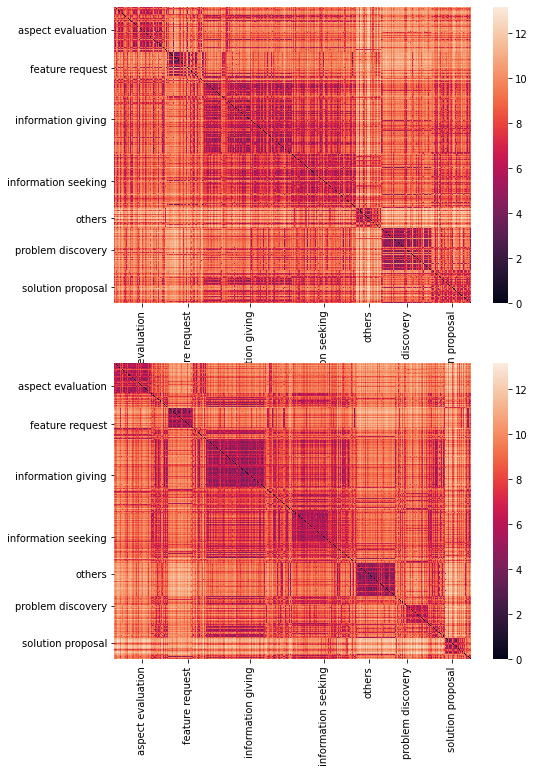

In [ ]:
# @title Run Analyses
from IPython.display import HTML
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn
import joblib
import os

def PrepareDataset(data):
  dataset = aim_parsed_text.StanfordFiles(projects=None)
  dataset.vec = []
  for text, pro, vec, lab in data:
    dataset.text.append(text)
    dataset.processed.append(pro)
    dataset.vec.append(vec)
    dataset.labels.append(lab)
  return dataset


drive_datafolder = os.path.join(drive_folder, 'data')

jfile = joblib.load(os.path.join(drive_datafolder, 'AIM_LSTM_bdtv_within_0.9.joblib'))
dataset_names = ['train_set', 'valid_set', 'test_set']
results = \
{
  "similar_little_big": pd.DataFrame(data=np.full((1, len(dataset_names)), np.nan), index=["corr(r_little, r_big)"], columns=dataset_names),
  "sorted_distances": {},
  "sorted_categories": {},
  "euclidean_little_mds": {},
  "precomputed_little_mds": {},
  "euclidean_big_mds": {},
  "precomputed_big_mds": {},
}
torch.set_printoptions(threshold=10)
# for dname in dataset_names:
#   dset = PrepareDataset(sorted(jfile[dname], key=lambda x: x[-1]))
#   little_dipper, big_dipper, cats = NNStanfordTensor2Prediction(jfile['model'], dset)
#   joblib.dump(
#     {
#         'little_dipper': little_dipper,
#         'big_dipper': big_dipper,
#         'cats': cats
#     },
#     os.path.join(drive_folder, 'out', '{}_{}.joblib'.format(list(jfile['model'].named_children())[1][0], dname))
#   )

# for dname in dataset_names:
#   saved = joblib.load(os.path.join(drive_folder, 'out', '{}_{}.joblib'.format(list(jfile['model'].named_children())[1][0], dname)))
#   little_dipper = saved['little_dipper']
#   big_dipper = saved['big_dipper']
#   cats = saved['cats']

#   little_sentence_distances, little_category_distances = CalculateDistance(little_dipper, cats, euclidean_distances)
#   big_sentence_distances, big_category_distances = CalculateDistance(big_dipper, cats, euclidean_distances)
#   prediction = [jfile['label_vocab'].itos[p] for p in torch.argmax(little_dipper, dim=1)]

#   # How similar are little_sentence_distances and big_sentence_distances?
#   results['similar_little_big'][dname][0] = np.corrcoef(little_sentence_distances.reshape(-1), big_sentence_distances.reshape(-1))[0,1]

#   # Sort similarity matrix
#   sorted_indices, results['sorted_categories'][dname] = zip(*sorted(enumerate(cats), key=lambda x: x[1]))
#   results['sorted_distances'][dname] = (big_sentence_distances[sorted_indices, :])[:, sorted_indices]
#   assert np.all(results['sorted_distances'][dname] == big_sentence_distances)

#   # How are the sentences distributed relative to each other? (colors = categories)
#   print('euclidean_little_mds')
#   results['euclidean_little_mds'][dname] = MDS(n_components=2, metric=True, dissimilarity='euclidean').fit_transform(little_dipper)
#   print('precomputed_little_mds')
#   results['precomputed_little_mds'][dname] = MDS(n_components=2, metric=True, dissimilarity='precomputed').fit_transform(little_sentence_distances)
#   print('euclidean_big_mds')
#   results['euclidean_big_mds'][dname] = MDS(n_components=2, metric=True, dissimilarity='euclidean').fit_transform(big_dipper)
#   print('precomputed_big_mds')
#   results['precomputed_big_mds'][dname] = MDS(n_components=2, metric=True, dissimilarity='precomputed').fit_transform(big_sentence_distances)
#   saved['results'] = results
#   joblib.dump(saved, os.path.join(drive_folder, 'out', '{}_{}_mds.joblib'.format(list(jfile['model'].named_children())[1][0], dname)))

mds_file = joblib.load(os.path.join(drive_folder, 'data', 'LSTM_mds.joblib'))
results = mds_file['results']
cats = mds_file['cats']
c = mds_file['results']
c['sorted_categories']

plt.rcParams['figure.figsize'] = [8, 16]
plt.figure()
_, ax = plt.subplots(nrows=2, ncols=1)

# mds_coords = [
#   results['euclidean_little_mds']['train_set'],  results['precomputed_little_mds']['train_set'],
#   results['euclidean_big_mds']['train_set'],  results['precomputed_big_mds']['train_set'],
# ]
# mds_cats = [
#   results['sorted_categories']['train_set'],  results['sorted_categories']['train_set'],
#   results['sorted_categories']['train_set'],  results['sorted_categories']['train_set'],
# ]
mds_coords = [
  results['precomputed_little_mds']['train_set'],
  results['precomputed_big_mds']['train_set'],
]
mds_cats = [
  results['sorted_categories']['train_set'],
  results['sorted_categories']['train_set']
]

colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1], [0.25,0.25, 1]]
for color, label in zip(colors, jfile['label_vocab'].itos):
    color.extend([0.5])
    # for axis, coords, cats in zip(itertools.chain(*ax), mds_coords, mds_cats):
    for axis, coords, cats in zip(itertools.chain(ax), mds_coords, mds_cats):
      axis.scatter(
          [x for x,lab in zip(coords[:,0], cats) if label == lab],
          [y for y,lab in zip(coords[:,1], cats) if label == lab],
          c=np.array(color, ndmin=2)
      )

# Plot similarity; expect to see 
# Sanity check
assert np.all(results['so rted_distances']['train_set']  == results['sorted_distances']['train_set'].T)
assert np.all(results['sorted_distances']['valid_set']  == results['sorted_distances']['valid_set'].T)
assert np.all(results['sorted_distances']['test_set']  == results['sorted_distances']['test_set'].T)

# Put category label in the middle of the category
# counter = Counter(results['sorted_categories']['train_set'])

# plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.figsize'] = [8, 20]
plt.figure()
_, ax = plt.subplots(3, 1)
PlotHeatMap(results['sorted_distances']['train_set'], results['sorted_categories']['train_set'], ax[0])
PlotHeatMap(results['sorted_distances']['valid_set'], results['sorted_categories']['valid_set'], ax[1])
PlotHeatMap(results['sorted_distances']['test_set'], results['sorted_categories']['test_set'], ax[2])
plt.show();

category_dict = \
{
 'aspect evaluation': [0, 1],
 'feature request': [2, 3],
 'information giving': [4, 5],
 'information seeking': [6, 7],
 'problem discovery': [8, 9],
 'solution proposal': [10, 11],
 'others': [12, 13],
}

pred = [jfile['label_vocab'].itos[p] for p in torch.argmax(mds_file['little_dipper'], dim=1)]
np.count_nonzero([c == p for c,p in zip(results['sorted_categories']['test_set'], pred)])
sorted_indices, _ = zip(*sorted(enumerate([category_dict[cat][cat != pred] for cat, pred in zip(results['sorted_categories']['test_set'], pred)]), key=lambda x: x[1]))
pred_sorted_distances = (results['sorted_distances']['test_set'][sorted_indices, :])[:, sorted_indices]
pred_sorted_categories = [results['sorted_categories']['test_set'][[ix] for ix in sorted_indices]
pred_sorted_pred = [pred[ix] for ix in sorted_indices]
pred_sorted_pred[:100]

plt.rcParams['figure.figsize'] = [8, 16]
plt.figure()
_, ax = plt.subplots(2, 1)
PlotHeatMap(results['sorted_distances']['test_set'], results['sorted_categories']['test_set'], ax[0])
PlotHeatMap(pred_sorted_distances, pred_sorted_categories, ax[1])
plt.show();
# seaborn.heatmap(results['sorted_distances']['train_set'], ax=ax[0])
# ax[0].set_xticks([nb/2 for nb in counter.values()])
# ax[0].set_xticklabels([cat for cat in counter.keys()])
# a = seaborn.heatmap(results['sorted_distances']['valid_set'], ax=ax[1])
# b = ax[0]
# cats
# # b.set_xticks(
# seaborn.heatmap(results['sorted_distances']['test_set'], ax=ax[2])
# plt.show()


# np.all(little_sentence_distances == little_sentence_distances.T)
# np.all(results['sorted_distances'][dname]  == results['sorted_distances'][dname].T)

# display(HTML('<p>One question one might reasonably ask is: how similar are the <em>little dipper</em> and <em>big_dipper</em>?'))
# display(HTML('The answer:'))
# display(HTML(results['similar_little_big'].to_html().replace("r_little", "r<sub>little</sub>").replace("r_big", "r<sub>big</sub>")))
#   # 


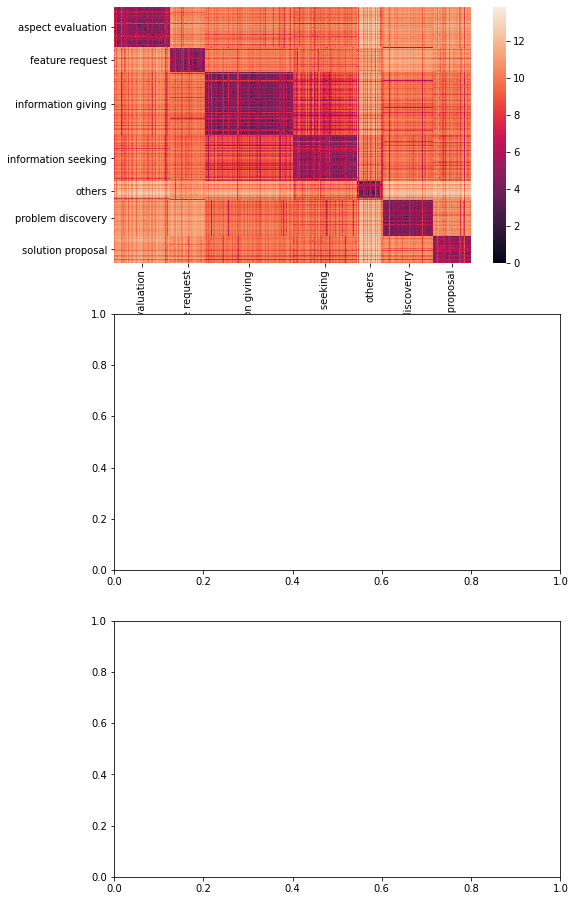

In [ ]:
counter = Counter(results['sorted_categories']['train_set'])
plt.figure
_, ax = plt.subplots(3, 1)
seaborn.heatmap(results['sorted_distances']['train_set'], ax=ax[0])
ticks = np.array(list(counter.values()))
ticks = ticks/2 + np.cumsum(np.append(np.zeros((1,1)), ticks[:-1]))
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([cat for cat in counter.keys()])
ax[0].set_yticks(ticks)
ax[0].set_yticklabels([cat for cat in counter.keys()])
plt.show();

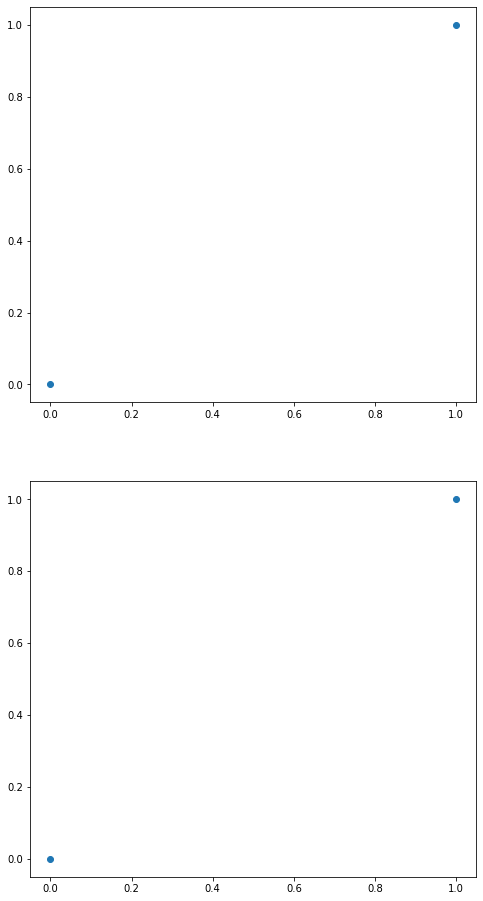

this is a test


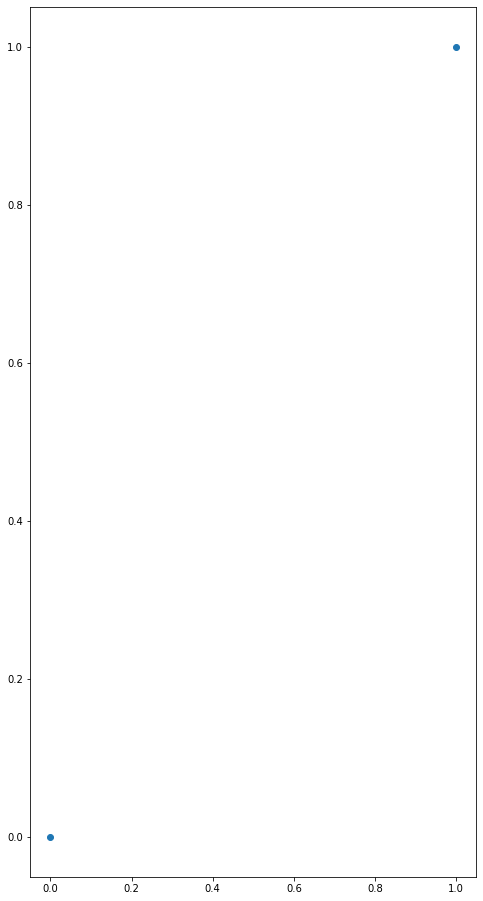

In [ ]:
_, ax = plt.subplots(nrows=2, ncols=1)
ax[0].scatter([0, 1], [0, 1])
ax[1].scatter([0, 1], [0, 1])
plt.show()
print('this is a test')
plt.figure()
plt.scatter([0, 1], [0, 1])
plt.show();

In [ ]:
# import matplotlib.pyplot as plt
# import joblib
# import nltk
# from nltk.corpus import stopwords
# stopwords.words('english')

# # NaiveBayes, LogisticRegression, and SVM
# models, nb_lg_svm_params, label_to_int = \
#   joblib.load("AIM_NB_LG_SVM.joblib")

# train_valid_set = aim_parsed_text.StanfordFiles(["bootstrap", "docker", "tensorflow", "vscode"])
# train_valid_set.shuffle()
# train_valid_set.Preprocess(train_valid_set)

# test_set = aim_parsed_text.StanfordFiles(["DECA"])
# train_valid_set.Preprocess(test_set)

# ttt = [sent for sent, _ in test_set][:20]

# for model_name in models:
#   models[model_name]['tfidf'].preprocessor = lambda x: x
#   models[model_name]['tfidf'].tokenizer = lambda sent: [str(t) for t in sent.tokens]
#   prediction = models[model_name].predict(train_valid_set.processed)
#   print(models[model_name].predict(ttt))

#   # train
#   train_count = 0;
#   for lab, pre in zip(train_valid_set.labels, prediction):
#     if label_to_int[lab] == pre:
#       train_count = 1 + train_count
#   prediction = models[model_name].predict(test_set.processed)

#   # test
#   test_count = 0;
#   for lab, pre in zip(test_set.labels, prediction):
#     if label_to_int[lab] == pre:
#       test_count = 1 + test_count

#   #print
#   print(train_count / len(train_valid_set.processed), test_count / len(test_set.processed))

# #prediction = models['NaiveBayes'].predict(test_set.processed)

In [ ]:
# @title Model similarity

from torch.utils.data import DataLoader
import numpy as np
import torch

def CalculateSimilarity(dataset, model):


lstm = joblib.load(os.path.join(drive_folder, 'data', 'AIM_LSTM_bdtv_within_0.9.joblib'))
train_set = aim_parsed_text.StanfordFiles(projects=None)
train_set.vec = []
for text, pro, vec, lab in lstm['train_set']:
  train_set.text.append(text)
  train_set.processed.append(pro)
  train_set.vec.append(vec)
  train_set.labels.append(lab)

train_set.sort_by_labels()
 

In [ ]:
# @title X
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np
import joblib
import torch
import os
import gc

lstm = joblib.load(os.path.join(drive_folder, 'data', 'AIM_LSTM_bdtv_within_0.9.joblib'))
train_set = aim_parsed_text.StanfordFiles(projects=None)
train_set.vec = []
for text, pro, vec, lab in lstm['train_set']:
  train_set.text.append(text)
  train_set.processed.append(pro)
  train_set.vec.append(vec)
  train_set.labels.append(lab)

train_set.sort_by_labels()

train_loader = DataLoader(train_set, batch_size=128, shuffle=False)
little_dipper = []
little_cat = []
big_dipper = []
big_cat = []
# little_dipper = torch.full((len(lstm['train_set']), 7), np.nan)
# big_dipper = torch.full((len(lstm['train_set']), 512), np.nan)
for ix, ts in enumerate(train_loader):
  little, big = lstm['model'].forward_plus(ts[0])
  little_dipper.append(little.detach())
  big_dipper.append(big.detach())
  little_cat.extend(ts[1])
  big_cat.extend(ts[1])
  # if ix >= 4:
  #   break

little_dipper = torch.cat(little_dipper, dim=0)
little_dipper.size()
big_dipper = torch.cat(big_dipper, dim=0)
big_dipper.size()

little_r = np.corrcoef(little_dipper.numpy())
big_r = np.corrcoef(big_dipper.numpy())

joblib.dump(
  {
    'little_r': little_r,
    'big_r': big_r,
    'little_cat': little_cat,
    'big_cat': big_cat,
  }, os.path.join(drive_folder, 'tmp.joblib')
)
# little_dipper = []
# # little_dipper = torch.full((len(lstm['train_set']), 7), np.nan)
# # big_dipper = torch.full((len(lstm['train_set']), 512), np.nan)
# for ix, ts in enumerate(lstm['train_set'][:500]):
#   # little_dipper[ix], big_dipper[ix] = lstm['model'].forward_plus(torch.unsqueeze(ts[2], 0))
#   # little_dipper[ix][:], _ = lstm['model'].forward_plus(torch.unsqueeze(ts[2], 0))
#   little, _ = lstm['model'].forward_plus(torch.unsqueeze(ts[2], 0))
#   little_dipper.append(little)
#   # wtv, tmp = lstm['model'].forward_plus(torch.unsqueeze(ts[2], 0))

ERROR! Session/line number was not unique in database. History logging moved to new session 59


['/gdrive/My Drive/COMP762_IntentionMining/tmp.joblib']

In [ ]:
import joblib
import numpy as np

a = joblib.load(os.path.join(drive_folder, 'tmp.joblib'))
little_r = a['little_r']
big_r = a['big_r']
cats = a['little_cat']

big_r.shape

categories = set(cats)
data = {c: {c2: [] for c2 in categories} for c in categories}

for ix, C1 in enumerate(cats):
  for jx, C2 in enumerate(cats):
    if ix != jx:
      data[C1][C2].append(little_r[ix][jx])

results = {c: { c2: [np.mean(r), np.std(r)] for c2, r in d.items()} for c, d in data.items()}

for C1 in cats:
  results[C1]['_self'] = results[C1][C1]
  results[C1]['_except'] = []
  for C2 in cats:
    if C2 != C1:
      results[C1]['_except'].extend(results[C1][C2])
  results[C1]['_except'] = [np.mean(results[C1]['_except']), np.std(results[C1]['_except'])]

results['aspect evaluation']

{'_except': [0.06483675537418285, 0.15598020348010003],
 '_self': [0.9141175209773377, 0.13528534402685624],
 'aspect evaluation': [0.9141175209773377, 0.13528534402685624],
 'feature request': [0.15628273743627294, 0.18467054084808815],
 'information giving': [0.08368755587791364, 0.174834731022582],
 'information seeking': [-0.1932000371519338, 0.19107694555857177],
 'others': [-0.3382002952504354, 0.17792679876433037],
 'problem discovery': [-0.11259940558741742, 0.16668954255042007],
 'solution proposal': [-0.020331527399554027, 0.17887916934327103]}

In [ ]:
# @title Define var models = {'LSTM', lstm_predict(...), ...} 
# import joblib

# #### NOTE
# # This function is *crucial*! If the lambda function is created directly in the
# # loop, the pipeline that is used is the last one (since the lambda expression
# # *closes* over the global pipeline) [In other words, the loop does not have scope
# # so the variable that is used is the general one.] 
# def create_model_predict_func(pipeline, int_to_label):
#   return lambda sent: [int_to_label[cat] for cat in pipeline.predict(sent)]

# models = {}

# # NaiveBayes, LogisticRegression, and SVM
# nb_lg_svm, nb_lg_svm_params, nb_lg_svm_label_vocab = \
#   joblib.load('AIM_NB_LG_SVM.joblib')
# nb_lg_svm_label_vocab = [cat for cat, _ in sorted(nb_lg_svm_label_vocab.items(), key=lambda tup: tup[1])]
# for model_name, pipeline in nb_lg_svm.items():
#   pipeline['tfidf'].preprocessor = lambda sent: sent
#   pipeline['tfidf'].tokenizer = lambda sent: [str(t) for t in sent.tokens] 
#   models[model_name] = create_model_predict_func(pipeline, nb_lg_svm_label_vocab)

# # LSTM
# lstm_params, lstm_model = joblib.load('AIM_LSTM.joblib')
# lstm_model = lstm_model['DECA']
# models['LSTM'] = lambda processed_text: NNPredictStanford \
# (
#   lstm_model['model'], lstm_model['text_vocab'], lstm_model['label_vocab'],
#   lstm_params['_padded_string_length'], processed_text
# )

# # CNN
# cnn_params, cnn_model = joblib.load('AIM_CNN.joblib')
# cnn_model = cnn_model['DECA']
# models['CNN'] = lambda processed_text: NNPredictStanford \
# (
#   cnn_model['model'], cnn_model['text_vocab'], cnn_model['label_vocab'],
#   cnn_params['_padded_string_length'], processed_text
# )
# ttt.append(models['LSTM']([sent for sent, _ in test_set]))
# ttt.append(models['CNN']([sent for sent, _ in test_set]))
# np.sum([a == b for a, b in zip(ttt[3], [lab for _, lab in test_set])]) / len(test_set)

# # Make sure that all models are working as expected
# test_set = aim_parsed_text.StanfordFiles(["DECA"])
# test_set.Preprocess(test_set)
# sentences = [sent for sent, _ in test_set]
# labels = [lab for _, lab in test_set]
# ttt = [
#   models['NaiveBayes'](sentences),
#   models['LogisticRegression'](sentences),
#   models['SVM'](sentences),
#   models['LSTM'](sentences),
#   models['CNN'](sentences)
# ]
# print(
#   "{:.6f} {:.6f} {:.6f} {:.6f} {:.6f}".format(
#     np.sum([a == b for a, b in zip(ttt[0], labels)]) / len(ttt[0]), 
#     np.sum([a == b for a, b in zip(ttt[1], labels)]) / len(ttt[0]),
#     np.sum([a == b for a, b in zip(ttt[2], labels)]) / len(ttt[0]),
#     np.sum([a == b for a, b in zip(ttt[3], labels)]) / len(ttt[0]),
#     np.sum([a == b for a, b in zip(ttt[4], labels)]) / len(ttt[0])
#   )
# )
# print(
#   "{:.6f} {:.6f} {:.6f} {:.6f} {:.6f}".format(
#     np.sum([a == b for a, b in zip(ttt[0], ttt[1])]) / len(ttt[0]), 
#     np.sum([a == b for a, b in zip(ttt[0], ttt[2])]) / len(ttt[0]),
#     np.sum([a == b for a, b in zip(ttt[1], ttt[2])]) / len(ttt[0]),
#     np.sum([a == b for a, b in zip(ttt[0], ttt[3])]) / len(ttt[0]),
#     np.sum([a == b for a, b in zip(ttt[3], ttt[4])]) / len(ttt[0])
#   )
# )


In [ ]:
# import sklearn.manifold
# import matplotlib.pyplot as plt
# import numpy as np
# import joblib
 
# # plt.figure(figsize=(7,7))
# # _, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# plt.figure(figsize=(7,7))
# ax = [plt]
# colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1], [0.25,0.25, 1]]
# for ii in range(len(label_names)):
#     colors[ii].extend([0.5])
#     ax[0].scatter(
#         [x for x,lab in zip(mds_r[:,0],label) if ii == lab],
#         [y for y,lab in zip(mds_r[:,1],label) if ii == lab],
#         c = np.array(colors[ii], ndmin=2)
#     )

# # predicted = []
# # for target_project in set(project):
# #     predicted.extend([int(predictions[target_project][t]) for t,p in zip(text, project) if p == target_project])

# # predictions = Predict(aim.cpu(), text)
# # colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1], [0.25,0.25, 1]]
# # ct = 0
# # for ii in range(len(label_names)):
# #     colors[ii].extend([0.5])
# #     ct += len([x for x,pre in zip(mds_r[:,0],predicted) if ii == pre])
# #     ax[1].scatter(
# #         [x for x,pre in zip(mds_r[:,0],predicted) if ii == pre],
# #         [y for y,pre in zip(mds_r[:,1],predicted) if ii == pre],
# #         c = np.array(colors[ii], ndmin=2)
# #     )
# # plt.show();
